# Complete Embedding Model Finetuning Pipeline

This notebook demonstrates the **complete end-to-end workflow** for finetuning an embedding model and proving its performance improvement.

**Note:** This notebook uses the **same production parameters** as `train.py` and `config.py` for exact replication.

## Pipeline Overview

1. **Exploratory Data Analysis (EDA)** - Understand KorQuAD dataset structure and statistics
2. **Prepare Training Data** - Convert QA pairs to contrastive learning format
3. **Load Model and Setup LoRA** - Apply LoRA to intfloat model for efficient training
4. **Train the Model** - Finetune with InfoNCE loss
5. **Save Finetuned Model** - Persist trained model and training info
6. **Load Cleaned Wiki Text** - Prepare evaluation data chunks
7. **Load Both Models** - Load original and finetuned models for comparison
8. **Evaluate with OpenAI** - Use OpenAI embeddings as neutral benchmark
9. **Analyze Results** - Compare performance metrics
10. **Save Results** - Export evaluation data and visualizations

## Starting Point

We start with only:
- **KorQuAD dataset** in `D:\datasets\KorQuAD` (or `/mnt/d/datasets/KorQuAD` in WSL)
- **Cleaned wiki text** in `data/text_cleaned.txt`

## Goal

**Prove that the finetuned model achieves better similarity scores than the original model when evaluated with OpenAI embeddings as a neutral benchmark.**

---

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import torch
import numpy as np
import json
import re
from html import unescape
from typing import List, Tuple
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"📁 Project root: {project_root}")
print(f"📁 Working directory: {os.getcwd()}")
print(f"🖥️  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

📁 Project root: c:\Users\dabsd\projects\project-intfloat
📁 Working directory: c:\Users\dabsd\projects\project-intfloat\submission
🖥️  Device: CUDA
🎮 GPU: NVIDIA GeForce RTX 2080


---

## Step 1: Exploratory Data Analysis (EDA)

Before training, let's load and explore the KorQuAD dataset to understand its structure and characteristics.

In [2]:
# Load KorQuAD dataset
print("📥 Loading KorQuAD dataset for EDA...")
sys.path.insert(0, str(project_root))
from dataloader.loader import load_entire_dataset

dataset_root = "D:\\datasets\\KorQuAD"
dataset = load_entire_dataset(dataset_root, num_workers=2)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Total articles: {len(dataset['articles'])}")

# Count total QA pairs
total_qas = sum(len(article.get('qas', [])) for article in dataset['articles'])
print(f"📊 Total QA pairs: {total_qas}")

📥 Loading KorQuAD dataset for EDA...
Found 36 JSON files
Loading files using 2 worker processes...

Successfully loaded 36/36 files
Accumulating data...


✅ Dataset loaded successfully!
📊 Total articles: 35496
📊 Total QA pairs: 78119


### One Sample

Let's see how one sample looks like

In [3]:
print("Single file: :", dataset["files"][0])

print("Single article: ")
for k,v in dataset["articles"][0].items():
    print(f"{k}: {v}")

Single file: : D:\datasets\KorQuAD\KorQuAD_2.1_train_00\korquad2.1_train_00.json
Single article: 
title: 예고범
url: https://ko.wikipedia.org/wiki/예고범
context: <!DOCTYPE html>
<html>
<head>
<meta>
<title>예고범 - 위키백과, 우리 모두의 백과사전</title>


<link>

<meta>
<link>
<meta>
<meta>
<meta>
<meta>
<link>
<link>
<link>
<link>
<link>
<link>
<link>
<link>
<link>
<link>
<link>

</head>
<body>
<div></div>
<div></div>
<div>
<a></a>
<div></div>
<div>
</div>
<h1>예고범</h1>
<div>
<div>위키백과, 우리 모두의 백과사전.</div>
<div></div>
<div></div>
<a>둘러보기로 가기</a>
<a>검색하러 가기</a>
<div><div><p>《<b>예고범</b>》(<span><a>일본어</a>: </span><span>予告犯</span>)은, 츠츠이 테츠야의 <a>만화</a> 작품이다.
</p>
<div><input><div><h2>목차</h2><span><label></label></span></div>
<ul>
<li><a><span>1</span> <span>개요</span></a></li>
<li><a><span>2</span> <span>등장인물</span></a>
<ul>
<li><a><span>2.1</span> <span>예고범 그룹</span></a></li>
<li><a><span>2.2</span> <span>경찰 관계자</span></a></li>
<li><a><span>2.3</span> <span>타깃이 된 인물·기업·단체</span></a></li>
<li><a><span>2.4</span>

### Text Length Analysis

Let's analyze the length distribution of questions and answers in the dataset.

In [4]:
# Analyze question and answer lengths
question_lengths = []
answer_lengths = []

print("📊 Analyzing text lengths...")
for article in tqdm(dataset['articles'], desc="Processing articles"):
    for qa in article.get('qas', []):
        question = qa.get('question', '')
        answer_obj = qa.get('answer', {})
        
        # Extract answer text
        if isinstance(answer_obj, dict):
            answer = answer_obj.get('text', '')
        elif isinstance(answer_obj, str):
            answer = answer_obj
        else:
            answer = ''
        
        if question:
            question_lengths.append(len(question))
        if answer:
            answer_lengths.append(len(answer))

# Calculate statistics
print(f"\n📈 Question Length Statistics:")
print(f"  - Average: {np.mean(question_lengths):.1f} characters")
print(f"  - Median: {np.median(question_lengths):.1f} characters")
print(f"  - Min: {np.min(question_lengths)} characters")
print(f"  - Max: {np.max(question_lengths)} characters")

print(f"\n📈 Answer Length Statistics:")
print(f"  - Average: {np.mean(answer_lengths):.1f} characters")
print(f"  - Median: {np.median(answer_lengths):.1f} characters")
print(f"  - Min: {np.min(answer_lengths)} characters")
print(f"  - Max: {np.max(answer_lengths)} characters")

📊 Analyzing text lengths...


Processing articles:   0%|          | 0/35496 [00:00<?, ?it/s]


📈 Question Length Statistics:
  - Average: 32.1 characters
  - Median: 30.0 characters
  - Min: 5 characters
  - Max: 146 characters

📈 Answer Length Statistics:
  - Average: 161.3 characters
  - Median: 9.0 characters
  - Min: 1 characters
  - Max: 13063 characters


### Visualize Length Distributions

In [5]:
# Sample data inspection completed in EDA section above
# Proceeding with training data preparation

In [6]:
# Analyze question types based on Korean question words
question_types = {
    '무엇': 0,  # what
    '누구': 0,  # who
    '언제': 0,  # when
    '어디': 0,  # where
    '왜': 0,    # why
    '어떻게': 0, # how
    '몇': 0,    # how many
    '어느': 0,  # which
    '기타': 0   # other
}

print("📊 Analyzing question types...")
for article in dataset['articles']:
    for qa in article.get('qas', []):
        question = qa.get('question', '')
        
        # Classify question type
        classified = False
        for qtype in ['무엇', '누구', '언제', '어디', '왜', '어떻게', '몇', '어느']:
            if qtype in question:
                question_types[qtype] += 1
                classified = True
                break
        
        if not classified:
            question_types['기타'] += 1

# Display results
print(f"\n📋 Question Type Distribution:")
print("=" * 50)
total = sum(question_types.values())
for qtype, count in sorted(question_types.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {qtype:8s}: {count:6,} ({percentage:5.2f}%)")
print("=" * 50)
print(f"  {'Total':8s}: {total:6,} (100.00%)")

📊 Analyzing question types...

📋 Question Type Distribution:
  기타      : 32,219 (41.24%)
  무엇      : 13,995 (17.91%)
  몇       :  9,411 (12.05%)
  누구      :  5,942 ( 7.61%)
  언제      :  5,838 ( 7.47%)
  어디      :  4,730 ( 6.05%)
  어떻게     :  3,609 ( 4.62%)
  어느      :  2,189 ( 2.80%)
  왜       :    186 ( 0.24%)
  Total   : 78,119 (100.00%)


### Question Type Analysis

In [7]:
# Show sample articles and QA pairs
print("📄 Sample Articles and QA Pairs:")
print("=" * 80)

for i in range(min(3, len(dataset['articles']))):
    article = dataset['articles'][i]
    print(f"\n[Article {i+1}]")
    print(f"  Title: {article.get('title', 'N/A')}")
    print(f"  URL: {article.get('url', 'N/A')}")
    print(f"  QA pairs: {len(article.get('qas', []))}")
    
    # Show first QA pair
    if article.get('qas'):
        qa = article['qas'][0]
        print(f"\n  Sample QA:")
        print(f"    Q: {qa.get('question', 'N/A')}")
        answer_obj = qa.get('answer', {})
        if isinstance(answer_obj, dict):
            answer_text = answer_obj.get('text', 'N/A')
        else:
            answer_text = str(answer_obj)
        print(f"    A: {answer_text[:100]}{'...' if len(answer_text) > 100 else ''}")
    print("-" * 80)

print("\n✅ EDA Complete - Ready for training!")

📄 Sample Articles and QA Pairs:

[Article 1]
  Title: 예고범
  URL: https://ko.wikipedia.org/wiki/예고범
  QA pairs: 1

  Sample QA:
    Q: 드라마 예고범의 감독은 누구일까?
    A: 나카무라 요시히로, 히라바야시 카츠토시, 사와다 메구미
--------------------------------------------------------------------------------

[Article 2]
  Title: 심규언
  URL: https://ko.wikipedia.org/wiki/심규언
  QA pairs: 1

  Sample QA:
    Q: 심규언은 17대 지방 선거에서 몇 표를 득표하였는가?
    A: 20,890 표
--------------------------------------------------------------------------------

[Article 3]
  Title: 장기_이식
  URL: https://ko.wikipedia.org/wiki/장기_이식
  QA pairs: 1

  Sample QA:
    Q: 장기이식으로 인해 얻을 수 있는 효과는?
    A: 자유 시장이 장기 이식에서의 희소성 문제를 해결할 수 있다고 말했다.
--------------------------------------------------------------------------------

✅ EDA Complete - Ready for training!


---

## Step 2: Prepare Training Data

Now we'll convert the KorQuAD dataset to training examples for contrastive learning using E5 format.

### Define Training Data Preparation Function

This function will convert QA pairs to InputExample format with E5 prefixes.

In [8]:
from sentence_transformers import InputExample

def clean_html_text(text: str) -> str:
    """Clean HTML markup from text."""
    if not text:
        return ""
    
    text = re.sub(r'<!DOCTYPE[^>]*>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'<html[^>]*>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'</html>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'<head[^>]*>.*?</head>', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'<script[^>]*>.*?</script>', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'<style[^>]*>.*?</style>', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = unescape(text)
    text = re.sub(r'\n\s*\n', '\n\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

def prepare_training_data(dataset, max_samples=None, train_split=0.9):
    """Convert KorQuAD to training examples."""
    print("\n🔄 Preparing training data...")
    
    examples = []
    articles = dataset['articles']
    
    # Limit for faster training (optional)
    if max_samples:
        print(f"⚠️  Limiting to {max_samples} samples for faster training")
        total_qas = 0
        limited_articles = []
        for article in articles:
            limited_articles.append(article)
            total_qas += len(article.get('qas', []))
            if total_qas >= max_samples:
                break
        articles = limited_articles
    
    # Convert to training examples
    for article in tqdm(articles, desc="Processing articles"):
        for qa in article.get('qas', []):
            question = qa.get('question', '')
            answer_obj = qa.get('answer', {})
            
            # Extract answer text
            if isinstance(answer_obj, dict):
                answer = answer_obj.get('text', '')
            elif isinstance(answer_obj, str):
                answer = answer_obj
            else:
                answer = ''
            
            if not question or not answer:
                continue
            
            # Clean HTML
            answer = clean_html_text(answer)
            if not answer:
                continue
            
            # Create training example with E5 prefixes
            example = InputExample(texts=[f"query: {question}", f"passage: {answer}"])
            examples.append(example)
    
    print(f"✅ Created {len(examples)} training examples")
    
    # Split train/val
    split_idx = int(len(examples) * train_split)
    train_examples = examples[:split_idx]
    val_examples = examples[split_idx:]
    
    print(f"📊 Train examples: {len(train_examples)}")
    print(f"📊 Val examples: {len(val_examples)}")
    
    return train_examples, val_examples

print("✅ Training data preparation function defined")

✅ Training data preparation function defined


### Create Training Examples

In [9]:
# Prepare training data (using full dataset to match train.py)
train_examples, val_examples = prepare_training_data(
    dataset,
    max_samples=None,  # Use full dataset (matches config.py)
    train_split=0.9
)


🔄 Preparing training data...


Processing articles:   0%|          | 0/35496 [00:00<?, ?it/s]

✅ Created 78114 training examples
📊 Train examples: 70302
📊 Val examples: 7812


In [10]:
print("Single Pair: ", train_examples[0].texts)

Single Pair:  ['query: 드라마 예고범의 감독은 누구일까?', 'passage: 나카무라 요시히로, 히라바야시 카츠토시, 사와다 메구미']


---

## Step 3: Load Model and Setup LoRA

We'll load the intfloat/multilingual-e5-small model and apply LoRA for efficient finetuning.

**LoRA Configuration:**
- Rank (r): 8
- Alpha: 16
- Dropout: 0.1
- Max sequence length: 256
- Target modules: query, key, value

In [11]:
import warnings
import sys
import os
from contextlib import contextmanager

# Suppress warnings
warnings.filterwarnings('ignore')

# Context manager to suppress stderr (for subprocess encoding issues)
@contextmanager
def suppress_stderr():
    """Temporarily redirect stderr to devnull to suppress subprocess encoding errors."""
    stderr = sys.stderr
    try:
        sys.stderr = open(os.devnull, 'w')
        yield
    finally:
        sys.stderr.close()
        sys.stderr = stderr

print("⚠️  Note: PEFT library may trigger a harmless UnicodeDecodeError in a background thread.")
print("   This is a known issue with subprocess encoding in Windows + conda environments.")
print("   The error does not affect functionality - LoRA will be applied successfully.\n")

⚠️  Note: PEFT library may trigger a harmless UnicodeDecodeError in a background thread.
   This is a known issue with subprocess encoding in Windows + conda environments.
   The error does not affect functionality - LoRA will be applied successfully.



### Load Base Model and Apply LoRA

In [12]:
from sentence_transformers import SentenceTransformer
from peft import LoraConfig, get_peft_model, TaskType

# Model configuration (matches config.py)
model_name = "intfloat/multilingual-e5-small"
device = "cuda" if torch.cuda.is_available() else "cpu"
max_seq_length = 256

print(f"📥 Loading base model: {model_name}")
model = SentenceTransformer(model_name, device=device)
model.max_seq_length = max_seq_length
print(f"✅ Model loaded on {device}")

# Get the underlying transformer model
auto_model = model[0].auto_model

# Configure LoRA (matches config.py)
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,  # Rank of LoRA matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],  # Apply to attention layers
    bias="none",
    inference_mode=False
)

# Apply LoRA to the model (suppress harmless subprocess encoding error)
print("\n🔧 Applying LoRA to model...")
with suppress_stderr():
    peft_model = get_peft_model(auto_model, lora_config)
model[0].auto_model = peft_model

# Print trainable parameters statistics
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_percentage = 100 * trainable_params / total_params

print(f"✅ LoRA applied successfully!")
print(f"📊 Trainable params: {trainable_params:,} / {total_params:,} ({trainable_percentage:.2f}%)")
print(f"📊 Memory savings: ~{100 - trainable_percentage:.1f}% reduction in trainable params")

📥 Loading base model: intfloat/multilingual-e5-small
✅ Model loaded on cuda

🔧 Applying LoRA to model...
✅ LoRA applied successfully!
📊 Trainable params: 221,184 / 117,874,944 (0.19%)
📊 Memory savings: ~99.8% reduction in trainable params


---

## Step 4: Train the Model

Configure training parameters and train using contrastive learning (InfoNCE loss).

**Training Configuration:**
- Batch size: 32
- Epochs: 3
- Learning rate: 2e-5
- Warmup steps: 500
- Full dataset training

In [13]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datetime import datetime

# Training configuration (matches config.py used in train.py)
batch_size = 32  # Production batch size
num_epochs = 3  # Full training
learning_rate = 2e-5
warmup_steps = 500  # Production warmup
max_steps = None  # Train to completion (no early stopping)

print("⚙️  Training Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Max steps: {max_steps if max_steps else 'No limit (full training)'}")

# Create data loader
train_dataloader = DataLoader(
    train_examples, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=lambda x: x  # Return as-is, we'll tokenize in training loop
)

# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler with warmup
total_steps = min(len(train_dataloader) * num_epochs, max_steps) if max_steps else len(train_dataloader) * num_epochs
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 
    start_factor=1e-6, 
    end_factor=1.0, 
    total_iters=warmup_steps
)

print(f"\n📊 Total training steps: {total_steps}")
print(f"📊 Steps per epoch: {len(train_dataloader)}")

⚙️  Training Configuration:
  Batch size: 32
  Epochs: 3
  Learning rate: 2e-05
  Warmup steps: 500
  Max steps: No limit (full training)

📊 Total training steps: 6591
📊 Steps per epoch: 2197


### Training Loop with InfoNCE Loss

Train the model using contrastive learning with in-batch negatives.

In [14]:
# Training loop
print("\n" + "="*80)
print("🚀 Starting Training...")
print("="*80 + "\n")

model.train()
global_step = 0
losses = []

for epoch in range(num_epochs):
    print(f"\n📚 Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch_idx, batch in enumerate(pbar):
        # Extract texts from batch
        query_texts = [example.texts[0] for example in batch]
        passage_texts = [example.texts[1] for example in batch]
        
        # Tokenize
        query_features = model.tokenize(query_texts)
        passage_features = model.tokenize(passage_texts)
        
        # Move to device
        query_features = {k: v.to(device) for k, v in query_features.items()}
        passage_features = {k: v.to(device) for k, v in passage_features.items()}
        
        # Forward pass
        query_embeddings = model(query_features)['sentence_embedding']
        passage_embeddings = model(passage_features)['sentence_embedding']
        
        # Normalize embeddings
        query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
        passage_embeddings = F.normalize(passage_embeddings, p=2, dim=1)
        
        # Compute similarity matrix with temperature scaling (InfoNCE)
        scores = torch.matmul(query_embeddings, passage_embeddings.t()) * 20.0
        
        # Labels: diagonal elements are positive pairs
        labels = torch.arange(len(query_embeddings), device=device)
        
        # InfoNCE loss via cross-entropy
        loss = F.cross_entropy(scores, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update scheduler (during warmup)
        if global_step < warmup_steps:
            scheduler.step()
        
        # Track loss
        epoch_loss += loss.item()
        losses.append(loss.item())
        global_step += 1
        
        # Update progress bar
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'avg_loss': f"{np.mean(losses[-100:]):.4f}"})
        
        # Check if max steps reached
        if max_steps and global_step >= max_steps:
            print(f"\n⚠️  Reached max steps ({max_steps}), stopping training...")
            break
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"✅ Epoch {epoch+1} completed - Avg Loss: {avg_epoch_loss:.4f}")
    
    if max_steps and global_step >= max_steps:
        break

print("\n" + "="*80)
print("✅ Training completed!")
print(f"📊 Total steps: {global_step}")
print(f"📊 Final loss: {losses[-1]:.4f}")
print(f"📊 Average loss (last 100 steps): {np.mean(losses[-100:]):.4f}")
print("="*80)


🚀 Starting Training...


📚 Epoch 1/3


Epoch 1:   0%|          | 0/2197 [00:00<?, ?it/s]

✅ Epoch 1 completed - Avg Loss: 1.5273

📚 Epoch 2/3


Epoch 2:   0%|          | 0/2197 [00:00<?, ?it/s]

✅ Epoch 2 completed - Avg Loss: 1.1095

📚 Epoch 3/3


Epoch 3:   0%|          | 0/2197 [00:00<?, ?it/s]

✅ Epoch 3 completed - Avg Loss: 1.0664

✅ Training completed!
📊 Total steps: 6591
📊 Final loss: 1.3059
📊 Average loss (last 100 steps): 1.0516


### Visualize Training Loss

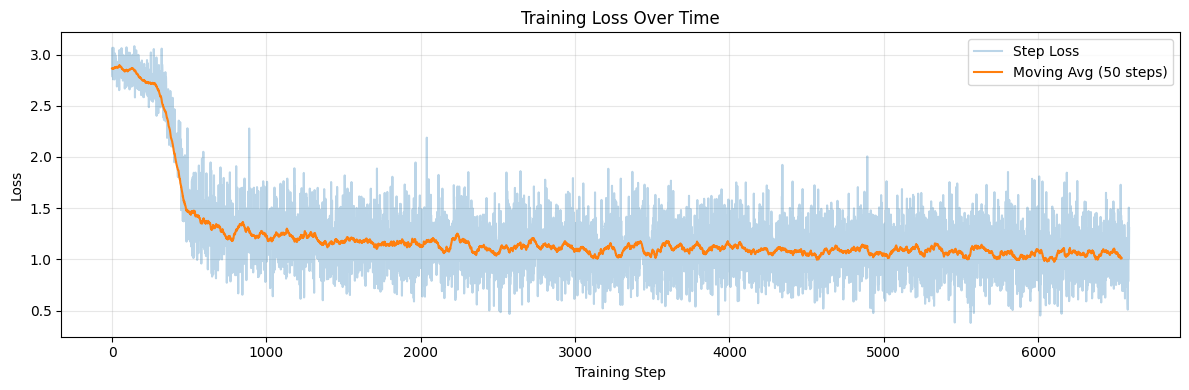

📊 Training loss plot saved to: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\training_loss.png


In [15]:
import matplotlib.pyplot as plt

# Create save directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = project_root / "submission" / f"finetuned_model_{timestamp}"
save_dir.mkdir(parents=True, exist_ok=True)

# Plot training loss
plt.figure(figsize=(12, 4))
plt.plot(losses, alpha=0.3, label='Step Loss')
plt.plot(np.convolve(losses, np.ones(50)/50, mode='valid'), label='Moving Avg (50 steps)')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir / 'training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Training loss plot saved to: {save_dir / 'training_loss.png'}")

---

## Step 5: Save Finetuned Model

Save the trained model and training metadata for later use.

In [16]:
# Save finetuned model
print(f"\n💾 Saving finetuned model to: {save_dir}")
model.save(str(save_dir))

# Save training info
training_info = {
    'model_name': model_name,
    'timestamp': timestamp,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'warmup_steps': warmup_steps,
    'total_steps': global_step,
    'final_loss': float(losses[-1]),
    'avg_loss_last_100': float(np.mean(losses[-100:])),
    'train_examples': len(train_examples),
    'val_examples': len(val_examples),
    'lora_config': {
        'r': 8,
        'lora_alpha': 16,
        'lora_dropout': 0.1,
        'target_modules': ['query', 'key', 'value']
    }
}

training_info_file = save_dir / 'training_info.json'
with open(training_info_file, 'w', encoding='utf-8') as f:
    json.dump(training_info, f, indent=2, ensure_ascii=False)

print(f"✅ Model saved successfully!")
print(f"✅ Training info saved to: {training_info_file}")


💾 Saving finetuned model to: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102
✅ Model saved successfully!
✅ Training info saved to: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\training_info.json


---

## Step 6: Load Cleaned Wiki Text and Create Chunks

Load the cleaned wiki text for evaluation and split it into chunks.

In [17]:
# Load and chunk wiki text
from utils.text_chunker import chunk_file

cleaned_text_path = project_root / "data" / "text_cleaned.txt"

print("📄 Loading and chunking wiki text for evaluation...")
chunks = chunk_file(
    file_path=str(cleaned_text_path),
    chunk_size=512,
    chunk_overlap=50,
    strategy="standard"
)

print(f"✅ Created {len(chunks)} chunks")
print(f"📊 Chunk size: 512 characters")
print(f"📊 Overlap: 50 characters")

print(f"\n📝 Sample chunk:")
print(chunks[0]['text'][:200] + "...")

📄 Loading and chunking wiki text for evaluation...
✅ Created 261 chunks
📊 Chunk size: 512 characters
📊 Overlap: 50 characters

📝 Sample chunk:
톰 마볼로 리들
Tom Marvolo Riddle
볼드모트
Voldemort
출생
1926년12월 31일
런던, 콜 원장의 고아원
성별
남성
혈통
혼혈
신체
190cm
기숙사
슬리데린
지팡이
주목나무 , 불사조의 깃털, 13½인치
경력
호그와트학생회장
보긴 앤 버크 직원
죽음을 먹는 자들지도자
상훈
호그와트 특별 공로상
볼드모트
최근 수정 시각: 2025-...


---

## Step 7: Load Both Models for Evaluation

Load the original (baseline) and finetuned models to compare their performance.

In [18]:
print("📥 Loading models for evaluation...\n")

# Load original model (baseline)
print("🔹 Loading original model: intfloat/multilingual-e5-small")
original_model = SentenceTransformer(model_name, device=device)
original_model.max_seq_length = max_seq_length
print(f"✅ Original model loaded")

# Load finetuned model (the one we just trained)
print(f"\n🔸 Loading finetuned model from: {save_dir}")
finetuned_model = SentenceTransformer(str(save_dir), device=device)
finetuned_model.max_seq_length = max_seq_length
print(f"✅ Finetuned model loaded")

print("\n🎯 Both models ready for evaluation!")

📥 Loading models for evaluation...

🔹 Loading original model: intfloat/multilingual-e5-small
✅ Original model loaded

🔸 Loading finetuned model from: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102
✅ Finetuned model loaded

🎯 Both models ready for evaluation!


---

## Step 8: Generate Embeddings

Generate embeddings for wiki chunks and define test queries for evaluation.

In [19]:
# Test queries related to Voldemort wiki content
test_queries = [
    "볼드모트는 누구인가?",
    "볼드모트의 본명은?",
    "볼드모트의 능력은?",
    "해리 포터와 볼드모트의 관계는?",
    "죽음을 먹는 자들이란?"
]

print("📋 Test Queries:")
for i, query in enumerate(test_queries, 1):
    print(f"  {i}. {query}")

📋 Test Queries:
  1. 볼드모트는 누구인가?
  2. 볼드모트의 본명은?
  3. 볼드모트의 능력은?
  4. 해리 포터와 볼드모트의 관계는?
  5. 죽음을 먹는 자들이란?


In [20]:
# Prepare chunk texts with E5 prefix
chunk_texts = [f"passage: {chunk['text']}" for chunk in chunks]

print("🔄 Generating embeddings for chunks...\n")

# Original model embeddings
print("📊 Original model:")
with torch.no_grad():
    original_embeddings = original_model.encode(
        chunk_texts,
        batch_size=32,
        show_progress_bar=True,
        normalize_embeddings=True
    )
print(f"✅ Generated {original_embeddings.shape[0]} embeddings (dim={original_embeddings.shape[1]})")

# Finetuned model embeddings
print("\n📊 Finetuned model:")
with torch.no_grad():
    finetuned_embeddings = finetuned_model.encode(
        chunk_texts,
        batch_size=32,
        show_progress_bar=True,
        normalize_embeddings=True
    )
print(f"✅ Generated {finetuned_embeddings.shape[0]} embeddings (dim={finetuned_embeddings.shape[1]})")

🔄 Generating embeddings for chunks...

📊 Original model:


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Generated 261 embeddings (dim=384)

📊 Finetuned model:


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Generated 261 embeddings (dim=384)


### Initialize OpenAI Client

In [21]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv(project_root / ".env")

# Get API key
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError(
        "OPENAI_API_KEY not found in environment variables. "
        "Please set it in your .env file."
    )

# Initialize OpenAI client
openai_client = OpenAI(api_key=api_key)

print("✅ OpenAI client initialized")
print("📊 Evaluation model: text-embedding-3-small")

✅ OpenAI client initialized
📊 Evaluation model: text-embedding-3-small


---

## Step 9: Evaluate with OpenAI Embeddings

Use OpenAI's `text-embedding-3-small` as a neutral benchmark to evaluate retrieval quality.

### Define Evaluation Functions

In [22]:
def retrieve_top_k(query_embedding, chunk_embeddings, chunks, top_k=5):
    """Retrieve top-k most similar chunks."""
    similarities = np.dot(chunk_embeddings, query_embedding)
    top_k_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = []
    for rank, idx in enumerate(top_k_indices, 1):
        results.append({
            'rank': rank,
            'text': chunks[idx]['text'],
            'score': float(similarities[idx])
        })
    return results

def get_openai_embedding(text):
    """Get embedding from OpenAI."""
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(response.data[0].embedding)

def evaluate_retrieval_quality(query, retrieved_chunks):
    """Evaluate using OpenAI embeddings."""
    query_emb = get_openai_embedding(query)
    
    similarities = []
    for chunk in retrieved_chunks:
        chunk_emb = get_openai_embedding(chunk['text'])
        similarity = np.dot(query_emb, chunk_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(chunk_emb))
        similarities.append(float(similarity))
    
    return {
        'avg_similarity': float(np.mean(similarities)),
        'max_similarity': float(np.max(similarities)),
        'similarities': similarities
    }

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


In [23]:
import time

TOP_K = 5
evaluation_results = []

print(f"🔬 Evaluating {len(test_queries)} queries with top-{TOP_K} retrieval...\n")
print("=" * 80)

for query_idx, query in enumerate(test_queries, 1):
    print(f"\n📋 Query {query_idx}/{len(test_queries)}: {query}")
    print("-" * 80)
    
    # Generate query embeddings
    with torch.no_grad():
        original_query_emb = original_model.encode(f"query: {query}", normalize_embeddings=True)
        finetuned_query_emb = finetuned_model.encode(f"query: {query}", normalize_embeddings=True)
    
    # Retrieve top-k chunks
    original_results = retrieve_top_k(original_query_emb, original_embeddings, chunks, TOP_K)
    finetuned_results = retrieve_top_k(finetuned_query_emb, finetuned_embeddings, chunks, TOP_K)
    
    print(f"⏳ Evaluating with OpenAI embeddings...")
    
    # Evaluate with OpenAI
    original_eval = evaluate_retrieval_quality(query, original_results)
    finetuned_eval = evaluate_retrieval_quality(query, finetuned_results)
    
    # Store results
    result = {
        'query': query,
        'original': original_eval,
        'finetuned': finetuned_eval,
        'improvement': finetuned_eval['avg_similarity'] - original_eval['avg_similarity'],
        'improvement_pct': ((finetuned_eval['avg_similarity'] - original_eval['avg_similarity']) / original_eval['avg_similarity'] * 100) if original_eval['avg_similarity'] > 0 else 0
    }
    evaluation_results.append(result)
    
    # Display results
    print(f"\n📊 Results:")
    print(f"  Original:  Avg={original_eval['avg_similarity']:.4f}, Max={original_eval['max_similarity']:.4f}")
    print(f"  Finetuned: Avg={finetuned_eval['avg_similarity']:.4f}, Max={finetuned_eval['max_similarity']:.4f}")
    print(f"  🎯 Improvement: {result['improvement']:.4f} ({result['improvement_pct']:+.2f}%)")
    
    if result['improvement'] > 0:
        print(f"  ✅ Finetuned model is BETTER")
    else:
        print(f"  ⚠️  Original model is better")
    
    # Small delay for rate limiting
    if query_idx < len(test_queries):
        time.sleep(1)

print("\n" + "=" * 80)
print("✅ Evaluation completed!")

🔬 Evaluating 5 queries with top-5 retrieval...


📋 Query 1/5: 볼드모트는 누구인가?
--------------------------------------------------------------------------------
⏳ Evaluating with OpenAI embeddings...

📊 Results:
  Original:  Avg=0.3418, Max=0.3943
  Finetuned: Avg=0.3744, Max=0.4517
  🎯 Improvement: 0.0326 (+9.53%)
  ✅ Finetuned model is BETTER

📋 Query 2/5: 볼드모트의 본명은?
--------------------------------------------------------------------------------
⏳ Evaluating with OpenAI embeddings...

📊 Results:
  Original:  Avg=0.3734, Max=0.4089
  Finetuned: Avg=0.4178, Max=0.4942
  🎯 Improvement: 0.0444 (+11.89%)
  ✅ Finetuned model is BETTER

📋 Query 3/5: 볼드모트의 능력은?
--------------------------------------------------------------------------------
⏳ Evaluating with OpenAI embeddings...

📊 Results:
  Original:  Avg=0.4073, Max=0.5559
  Finetuned: Avg=0.4208, Max=0.5559
  🎯 Improvement: 0.0135 (+3.31%)
  ✅ Finetuned model is BETTER

📋 Query 4/5: 해리 포터와 볼드모트의 관계는?
------------------------------------------

In [24]:
import pandas as pd

# Create summary dataframe
summary_data = []
for result in evaluation_results:
    summary_data.append({
        'Query': result['query'],
        'Original Avg': result['original']['avg_similarity'],
        'Finetuned Avg': result['finetuned']['avg_similarity'],
        'Improvement': result['improvement'],
        'Improvement %': result['improvement_pct']
    })

df_summary = pd.DataFrame(summary_data)

print("📊 EVALUATION SUMMARY")
print("=" * 100)
print(df_summary.to_string(index=False))
print("=" * 100)

📊 EVALUATION SUMMARY
            Query  Original Avg  Finetuned Avg  Improvement  Improvement %
      볼드모트는 누구인가?      0.341818       0.374382     0.032564       9.526798
       볼드모트의 본명은?      0.373421       0.417826     0.044405      11.891530
       볼드모트의 능력은?      0.407289       0.420774     0.013486       3.311109
해리 포터와 볼드모트의 관계는?      0.426355       0.430963     0.004608       1.080754
     죽음을 먹는 자들이란?      0.399594       0.350323    -0.049271     -12.330167


In [25]:
# Calculate overall statistics
avg_original = df_summary['Original Avg'].mean()
avg_finetuned = df_summary['Finetuned Avg'].mean()
avg_improvement = df_summary['Improvement'].mean()
avg_improvement_pct = df_summary['Improvement %'].mean()

wins_finetuned = (df_summary['Improvement'] > 0).sum()
wins_original = (df_summary['Improvement'] < 0).sum()

print("\n" + "=" * 100)
print("🏆 FINAL RESULTS")
print("=" * 100)
print(f"\n📈 Average Similarity Scores:")
print(f"  - Original Model:  {avg_original:.4f}")
print(f"  - Finetuned Model: {avg_finetuned:.4f}")
print(f"  - Improvement:     {avg_improvement:.4f} ({avg_improvement_pct:+.2f}%)")

print(f"\n🎯 Win/Loss Record:")
print(f"  - Finetuned Wins: {wins_finetuned}/{len(test_queries)}")
print(f"  - Original Wins:  {wins_original}/{len(test_queries)}")

print(f"\n" + "=" * 100)
if wins_finetuned > wins_original:
    print("✅ ✅ ✅ CONCLUSION: Finetuned model performs BETTER! ✅ ✅ ✅")
    print(f"   The finetuned model achieved higher similarity scores on {wins_finetuned}/{len(test_queries)} queries.")
else:
    print("⚠️  CONCLUSION: Original model performs better or equal.")
print("=" * 100)


🏆 FINAL RESULTS

📈 Average Similarity Scores:
  - Original Model:  0.3897
  - Finetuned Model: 0.3989
  - Improvement:     0.0092 (+2.70%)

🎯 Win/Loss Record:
  - Finetuned Wins: 4/5
  - Original Wins:  1/5

✅ ✅ ✅ CONCLUSION: Finetuned model performs BETTER! ✅ ✅ ✅
   The finetuned model achieved higher similarity scores on 4/5 queries.


---

## Step 10: Save Results

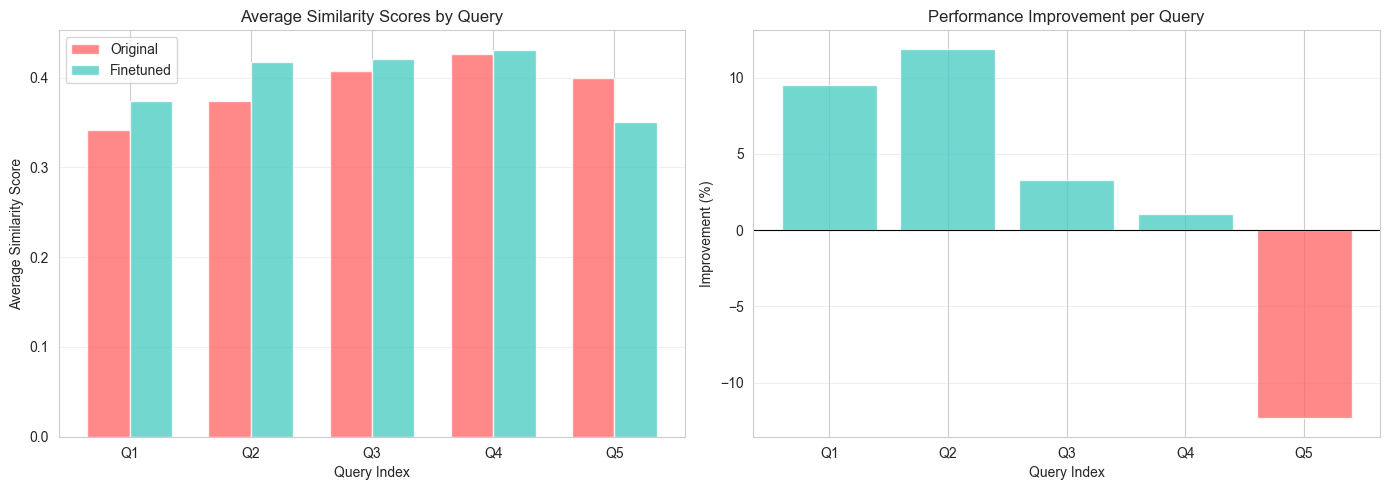

📊 Comparison plot saved to: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\evaluation_comparison.png


In [26]:
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
ax1 = axes[0]
x = range(len(test_queries))
width = 0.35
ax1.bar([i - width/2 for i in x], df_summary['Original Avg'], width, label='Original', alpha=0.8, color='#FF6B6B')
ax1.bar([i + width/2 for i in x], df_summary['Finetuned Avg'], width, label='Finetuned', alpha=0.8, color='#4ECDC4')
ax1.set_xlabel('Query Index')
ax1.set_ylabel('Average Similarity Score')
ax1.set_title('Average Similarity Scores by Query')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Q{i+1}' for i in x])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Improvement chart
ax2 = axes[1]
colors = ['#4ECDC4' if imp > 0 else '#FF6B6B' for imp in df_summary['Improvement %']]
ax2.bar(x, df_summary['Improvement %'], color=colors, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Query Index')
ax2.set_ylabel('Improvement (%)')
ax2.set_title('Performance Improvement per Query')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Q{i+1}' for i in x])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / 'evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Comparison plot saved to: {save_dir / 'evaluation_comparison.png'}")

In [27]:
# Save results to the same timestamped directory as the model
results_file = save_dir / 'evaluation_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump({
        'training': training_info,
        'evaluation': {
            'avg_original': float(avg_original),
            'avg_finetuned': float(avg_finetuned),
            'avg_improvement': float(avg_improvement),
            'avg_improvement_pct': float(avg_improvement_pct),
            'wins_finetuned': int(wins_finetuned),
            'wins_original': int(wins_original),
            'total_queries': len(test_queries)
        },
        'detailed_results': evaluation_results
    }, f, indent=2, ensure_ascii=False)

# Save CSV
csv_file = save_dir / 'evaluation_summary.csv'
df_summary.to_csv(csv_file, index=False, encoding='utf-8')

print(f"✅ Results saved to: {save_dir}")
print(f"  - Model: {save_dir}")
print(f"  - Training info: {save_dir / 'training_info.json'}")
print(f"  - Training loss plot: {save_dir / 'training_loss.png'}")
print(f"  - Evaluation results (JSON): {save_dir / 'evaluation_results.json'}")
print(f"  - Evaluation summary (CSV): {save_dir / 'evaluation_summary.csv'}")
print(f"  - Evaluation comparison plot: {save_dir / 'evaluation_comparison.png'}")

✅ Results saved to: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102
  - Model: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102
  - Training info: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\training_info.json
  - Training loss plot: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\training_loss.png
  - Evaluation results (JSON): c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\evaluation_results.json
  - Evaluation summary (CSV): c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\evaluation_summary.csv
  - Evaluation comparison plot: c:\Users\dabsd\projects\project-intfloat\submission\finetuned_model_20251107_022102\evaluation_comparison.png
